In [21]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Objective function

We sample from $$V_1(x_1, x_2) = 3(1 - x_1)^2 e^{-x_1^2 - (x_2 +1)^2} - 10 (x_1/5 - x_1 ^3 - x_2^5) e^{-x_1^2 - x_2 ^2} - 3 e^{- (x_1 + 2) ^2 - x_2^2} + 0.5(2x_1 + x_2)$$
$$V_2(x_1, x_2) = 3(1 +x_2)^2 e^{-x_2^2 - (x_1 +1)^2} - 10 (-x_2/5 + x_2 ^3 + x_1^5) e^{-x_1^2 - x_2 ^2} - 3 e^{- ( 2- x_2) ^2 - x_1^2} + 0.5(2x_1 + x_2)$$

where $(x_1, x_2) \in [-3, 3]^2$

In [22]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

In [23]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

## GP model initialization
We inialize the GP model following https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

In [24]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.222
Iter 2/50 - Loss: 1.182
Iter 3/50 - Loss: 1.140
Iter 4/50 - Loss: 1.099
Iter 5/50 - Loss: 1.058
Iter 6/50 - Loss: 1.017
Iter 7/50 - Loss: 0.977
Iter 8/50 - Loss: 0.937
Iter 9/50 - Loss: 0.897
Iter 10/50 - Loss: 0.859
Iter 11/50 - Loss: 0.821
Iter 12/50 - Loss: 0.784
Iter 13/50 - Loss: 0.747
Iter 14/50 - Loss: 0.710
Iter 15/50 - Loss: 0.672
Iter 16/50 - Loss: 0.633
Iter 17/50 - Loss: 0.594
Iter 18/50 - Loss: 0.556
Iter 19/50 - Loss: 0.517
Iter 20/50 - Loss: 0.479
Iter 21/50 - Loss: 0.441
Iter 22/50 - Loss: 0.404
Iter 23/50 - Loss: 0.369
Iter 24/50 - Loss: 0.335
Iter 25/50 - Loss: 0.303
Iter 26/50 - Loss: 0.273
Iter 27/50 - Loss: 0.244
Iter 28/50 - Loss: 0.217
Iter 29/50 - Loss: 0.192
Iter 30/50 - Loss: 0.168
Iter 31/50 - Loss: 0.147
Iter 32/50 - Loss: 0.128
Iter 33/50 - Loss: 0.111
Iter 34/50 - Loss: 0.098
Iter 35/50 - Loss: 0.087
Iter 36/50 - Loss: 0.079
Iter 37/50 - Loss: 0.074
Iter 38/50 - Loss: 0.070
Iter 39/50 - Loss: 0.069
Iter 40/50 - Loss: 0.069
Iter 41/5

# Hyperparamaters oprimization

tensor([[0.0087, 0.0072],
        [0.0069, 0.0059],
        [0.0054, 0.0048],
        [0.0044, 0.0040],
        [0.0036, 0.0034],
        [0.0031, 0.0029],
        [0.0027, 0.0025],
        [0.0025, 0.0023],
        [0.0024, 0.0022],
        [0.0023, 0.0021],
        [0.0023, 0.0020],
        [0.0023, 0.0020],
        [0.0023, 0.0020],
        [0.0023, 0.0020],
        [0.0023, 0.0020],
        [0.0023, 0.0020],
        [0.0022, 0.0019],
        [0.0022, 0.0019],
        [0.0022, 0.0019],
        [0.0021, 0.0019],
        [0.0021, 0.0019],
        [0.0021, 0.0019],
        [0.0020, 0.0018],
        [0.0020, 0.0018],
        [0.0020, 0.0018],
        [0.0019, 0.0018],
        [0.0019, 0.0017],
        [0.0019, 0.0017],
        [0.0019, 0.0017],
        [0.0019, 0.0017],
        [0.0019, 0.0017],
        [0.0019, 0.0017],
        [0.0019, 0.0017],
        [0.0019, 0.0017],
        [0.0019, 0.0017],
        [0.0019, 0.0017],
        [0.0019, 0.0017],
        [0.0019, 0.0017],
        [0.0

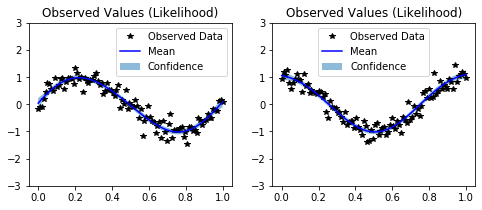

In [25]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = train_x
    predictions = (model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
    print(predictions.variance)

# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

None

# Design parameters and sampling point optimization

In [6]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

In [7]:
#x0 = Tensor(np.array([0.1937, 0.1257]))
#x0 = Tensor(np.array([0.1885, 0.1038]))

#x0 = x0_new #Tensor(np.array([0.8770, 0.5533]))
x0_new = Tensor(np.array([0.8770, 0.5533]))
x0 = x0_new.reshape(1,2)

print(vf(x0[:,0], x0[:,1]))
x0 = x0.reshape(1,2)
print(x0)
model.eval()
likelihood.eval()
# for param in model.named_parameters():
#         print(param)
noises = torch.ones(x0.shape) * (noise_value) 
with torch.no_grad():

    pr = model(x0) #likelihood(model(x0), noise = noises) #
    print(pr.confidence_region())
    print(pr.mean)

NameError: name 'Tensor' is not defined

In [ ]:
v2 = g_theta2_vec.reshape((iter)*(loc_size+1) + loc_size,2)


## RANDOM SEARCH

In [ ]:
class design_opti_pll(nn.Module):
    def __init__(self, x):
        super(design_opti_pll, self).__init__()
        #loc = np.random.random_sample((loc_size,2))
        #self.g_theta2 = nn.Parameter(Tensor(sample))
        self.x_design = nn.Parameter(Tensor(x))
    def forward(self):
       
        #g_theta2_new = self.g_theta2 #filter_sample(self.g_theta2, 0.009)
        
        return self.x_design

In [ ]:
def conduct_design_pll(x0,f_target, g_theta, agg_data, model, likelihood, training_design_iter, training_param_iter, lr_new):
    design = design_opti_pll(x0)
    loc_sample0 = loc_sample
    x_d = design.forward()
    def closure():
        optimizer.zero_grad()
        
        loss2,lower_bound, upper_bound = likelihood.get_pll(f_target,x_d, g_theta, agg_data, model, likelihood)
        #loss2 = -1. * loss2
        loss2.backward(retain_graph=True)
#         print(x_d)
#         print(lower_bound)
#         print(upper_bound)
       
        return loss2
        
        
        
    optimizer = torch.optim.LBFGS(design.parameters(), lr=lr_new, history_size=100, max_iter=100, line_search_fn="strong_wolfe")
    optimizer.step(closure)

    x_d = design.forward()
    loss2,lower_bound, upper_bound = likelihood.get_pll(f_target,x_d, g_theta, agg_data, model, likelihood)
    #loss2 = -1. * loss2
    print('Loss design: %.3f' % ( loss2))
   # print(optimizer.state_dict())
    print(x_d)
    return x_d, lower_bound, upper_bound

In [ ]:
# iter_hp = 30
# iter_design = 40 
# iter_param = 50
# num_base_kernels = 3

# f_target = Tensor(vf.tgt_vec) 
# f_target = f_target.reshape(f_target.shape[0],1) 
# tol_vector = 0.005 * torch.ones(f_target.shape)


loc_size_rdn = (iter + 1)*loc_size + sample_size

loc_sample = high_minus_low  * np.random.random_sample((loc_size_rdn,2)) + vf.low #np.random.random_sample((loc_size_rdn,2))
g_theta_ = (Tensor(loc_sample).clone())
agg_data1 = vfield_(g_theta_)
agg_data1 = agg_data1.flatten()
print(agg_data1.shape)

x0 = Tensor(np.array([0.0,0.0])) 
x0 = x0.reshape(1,2)
x00 = x0 
vec_x_rdn = Tensor(np.array([0.,0.])) 
vec_x_rdn = vec_x_rdn.reshape(1,2)

lr_new = 1.


SUCCESS = False 
FAILURE = False 
 
tol = 0.009 
print('START HYPERPARAMETERS optimization')
model_rdn, likelihood_rdn = hyper_opti(g_theta_,agg_data1,iter_hp,num_base_kernels,noise_value)

print('END HYPERPARAMETERS optimization')

x0_new,lower_bound, upper_bound = conduct_design_pll(x0,f_target, g_theta_, agg_data1, model_rdn, likelihood_rdn, iter_design, iter_param, lr_new)
print(lower_bound)
print(upper_bound)
print(f_target-tol_vector)
print(f_target+tol_vector)
loc_sample = np.random.random_sample((loc_size_rdn,2))


SUCCESS = stopping_criteria(tol_vector, f_target, lower_bound, upper_bound)


print(x0_new)
print(SUCCESS)
sol_rdn = x0_new

# TAD Plots and Vizualization

## First we vizualize the target function, namely, the contours of the coordinates of the outputs and its norm.

In [ ]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('font', size=15)          # controls default text sizes

In [ ]:
f_target = vf.tgt_vec
f_target = f_target.reshape(f_target.shape[0],1)
vf.tgt_loc = vf.tgt_loc.reshape(2,1)
x_plot = np.linspace(vf.low, vf.high, 30)
y_plot = np.linspace(vf.low, vf.high, 30)
xv_plot, yv_plot = np.meshgrid(x_plot, y_plot)
n = x_plot.shape[0]
x_concat = torch.zeros(n * n, 2)
i = 0
k = 0
while i < n*n:
    x_concat[i:i+n,0] = Tensor(xv_plot[:,k])
    x_concat[i:i+n,1] = Tensor(y_plot)
    k = k+1
    i = i+n
out_plot = vfield_(x_concat)


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (8, 18),  tight_layout=True)
v_1 = out_plot[:,0].reshape(n,n)
v_2 = out_plot[:,1].reshape(n,n)
v = np.sqrt(v_1**2 + v_2**2)
print(torch.max(v))

#pos = ax1.imshow(v_1, cmap='RdGy', interpolation='none')

cs1 = ax1.contourf(xv_plot, yv_plot,v_1, np.linspace(v_1.min(), v_1.max(), 100),cmap='jet')
ax1.plot(vf.tgt_loc[0],vf.tgt_loc[1], 'ks', markersize=12)
#cs11 = ax1.contour(xv_plot, yv_plot, v_1,np.linspace(v_1.min(), v_1.max(), 30),colors='w')
ax1.set_title('$v_1$')
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
cs2 = ax2.contourf(xv_plot, yv_plot, v_2, np.linspace(v_2.min(), v_2.max(), 100),cmap='jet')
ax2.plot(vf.tgt_loc[0],vf.tgt_loc[1], 'ks', markersize=12)
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
#cs21 = ax2.contour(xv_plot, yv_plot, v_2,colors='w')
ax2.set_title('$v_2$')
#ax2.set_aspect('equal')
sns.scatterplot(x=out_plot[:,0], y=out_plot[:,1], s=5, color=".15", ax = ax3)    #cs3 = ax3.contourf(xv_plot, yv_plot, v,np.linspace(v.min(), v.max(), 100),cmap='jet')
sns.histplot(x=out_plot[:,0], y=out_plot[:,1], bins=50, pthresh=.1, cmap="mako", ax = ax3)
sns.kdeplot(x=out_plot[:,0], y=out_plot[:,1], levels=5, color="w", linewidths=1, ax = ax3)

#ax3.plot(vf.tgt_loc[0],vf.tgt_loc[1], 'ks', markersize=12)
ax3.set_xlabel('$x_1$')
ax3.set_ylabel('$x_2$')
#cs31 = ax3.contour(xv_plot, yv_plot, v, np.linspace(v.min(), v.max(), 30),colors='w')
ax3.set_title('$scatter+hist$')
#ax3.set_aspect('equal')
cbar1 = fig.colorbar(cs1, ax = ax1);
#cbar1.add_lines(cs11)

cbar2 = fig.colorbar(cs2, ax = ax2);
#cbar2.add_lines(cs21)

#cbar3 = fig.colorbar(cs3, ax = ax3);
#cbar3.add_lines(cs31)
# ax01 = fig.add_subplot(3, 2, 2, projection='3d')
# ax02 = fig.add_subplot(3, 2, 4, projection='3d')
# ax03 = fig.add_subplot(3, 2, 6, projection='3d')

# ax01.plot3D(x_concat[:,0], x_concat[:,1], out_plot[:,0])

# ax02.plot3D(x_concat[:,0], x_concat[:,1], out_plot[:,1])



# ax03.plot3D(x_concat[:,0], x_concat[:,1], np.sqrt( (out_plot[:,1])**2 + (out_plot[:,0])**2))

plt.show()
plt.savefig('figures/target_fun.png')
# cs = plt.contourf(v_1, levels=[10, 30, 50],
#     colors=['#808080', '#A0A0A0', '#C0C0C0'], extend='both')
# cs.cmap.set_over('red')


In [ ]:
print(loc_size_rdn)


In [ ]:
loc_size = 4
i,j=0,0
low = -3.1
high = 3.1
PLOTS_PER_ROW = 2
widths = 16* np.ones((PLOTS_PER_ROW))
heights = 16 * np.ones((math.ceil((iter + 1)/PLOTS_PER_ROW)))
#print(heights)
gs_kw = dict(width_ratios=widths, height_ratios=heights)
#fig, ax = plt.subplots(math.ceil((iter + 1)/PLOTS_PER_ROW),PLOTS_PER_ROW, constrained_layout=True,
#                             gridspec_kw=gs_kw)
fig, axs = plt.subplots(math.ceil((iter+1)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(14, 28),  tight_layout=True)
ii = 0
# vec_x = Tensor([[0.5000, 0.7000],
#         [0.1427, 0.2234],
#         [0.1859, 0.1796],
#         [0.2023, 0.0953],
#         [0.1999, 0.0963],
#         [0.2003, 0.0998]])
col = 0

vec_x = vec_x.detach()
axs[i][j].plot(0.8731, 0.5664,'gs',markersize=12)
axs[i][j].plot(vec_x[col,0], vec_x[col,1],'rD',markersize=12)
axs[i][j].plot(x_train.detach()[:,0], x_train.detach()[:,1], 'bv', markersize=12)
axs[i][j].plot(v2.detach()[ii:ii+loc_size,0], v2.detach()[ii:ii+loc_size,1], 'yv', markersize=12)
axs[i][j].set_xlabel('$x_1$')
axs[i][j].set_ylabel('$x_2$')
axs[i][j].set_title('initial config')

#axs[i][j].set_aspect('equal')
if (ii > 0):
    axs[i][j].plot(v2.detach()[(ii-loc_size):ii,0], v2.detach()[ii-loc_size:ii,1], 'yv', markersize=12)
axs[i][j].set_xlim(low, high)
axs[i][j].set_ylim(low, high)
ii = ii+loc_size+1
j+=1

loc_size = loc_size
for col in range(1, iter+1):
    axs[i][j].plot(0.8731, 0.5664,'gs',markersize=12)
    axs[i][j].plot(vec_x[col,0], vec_x[col,1],'rD',markersize=12)
    axs[i][j].plot(v2.detach()[ii:ii+loc_size,0], v2.detach()[ii:ii+loc_size,1], 'bv', markersize=12)
  #  axs[i][j].set_aspect('equal')
    if (ii > loc_size):
        axs[i][j].plot(v2.detach()[(ii-loc_size):ii,0], v2.detach()[ii-loc_size:ii,1], 'yv', markersize=12)
    axs[i][j].set_xlim(low, high)
    axs[i][j].set_ylim(low, high)
    axs[i][j].set_xlabel('$x_1$')
    axs[i][j].set_ylabel('$x_2$')
    axs[i][j].set_title('stage %s' % col)
    ii = ii+loc_size+1
    j+=1
    
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
plt.show()
plt.savefig('figures/evol_sol.png')

In [ ]:
#x0 = Tensor(np.array([0.1937, 0.1257]))
#x0 = Tensor(np.array([0.1885, 0.1038]))
x_plot = np.linspace(vf.low, vf.high, 30)
y_plot = np.linspace(vf.low, vf.high, 30)
xv_plot, yv_plot = np.meshgrid(x_plot, y_plot)
sample_x, sample_y = g_theta1[:, 0].detach(), g_theta1[:, 1].detach()
n = x_plot.shape[0]
n_sample = sample_x.shape[0]
x_concat_ = torch.zeros(n_sample, 2)
x_concat_[:,0] = sample_x
x_concat_[:,1] = sample_y
# i = 0
# k = 0
# while i < n*n:
#     x_concat_[i:i+n,0] = Tensor(xv_plot[:,k])
#     x_concat_[i:i+n,1] = Tensor(y_plot)
#     k = k+1
#     i = i+n

model.eval()
#likelihood.eval()
print(x_concat_)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pr = likelihood(model(x_concat_), noise = torch.ones(x_concat_.shape) * noise_value)#  (model(x_concat_)) #

    mean_v_1 = pr.mean[:,0]#.reshape(n,n)
    mean_v_2 = pr.mean[:,1]#.reshape(n,n)


    var_v_1 = pr.variance[:,0]#.reshape(n,n)
    var_v_2 = pr.variance[:,1]#.reshape(n,n)
print(var_v_2)

# fig, (ax1, ax2) = plt.subplots(2, 2, figsize = (20, 16), tight_layout=True)
# cs10 = ax1[0].contourf(xv_plot, yv_plot, mean_v_1.detach(),np.linspace(mean_v_1.detach().min(), mean_v_1.detach().max(), 100), cmap = 'jet')
# ax1[0].plot(vf.tgt_loc[0],vf.tgt_loc[1], 'ks', markersize=12)
# ax1[0].set_title('$\mu(v_1)$', fontsize = 18)
# cbar10 = fig.colorbar(cs10, ax = ax1[0]);

# ax1[0].set_xlabel('$x_1$', fontsize = 16)
# ax1[0].set_ylabel('$x_2$', fontsize = 16)

# cs11 = ax1[1].contourf(xv_plot, yv_plot, var_v_1.detach(), np.linspace(var_v_1.detach().min(), var_v_1.detach().max(), 100), cmap = 'jet')
# ax1[1].plot(vf.tgt_loc[0],vf.tgt_loc[1], 'ks', markersize=12)
# ax1[1].set_title('$\sigma^2(v_1)$', fontsize = 18)
# # ax1[0].set_aspect('equal')
# # ax1[1].set_aspect('equal')
# cbar11 = fig.colorbar(cs11, ax = ax1[1]);
# ax1[1].set_xlabel('$x_1$', fontsize = 16)
# ax1[1].set_ylabel('$x_2$', fontsize = 16)


# cs20 = ax2[0].contourf(xv_plot, yv_plot, mean_v_2.detach(),np.linspace(mean_v_2.detach().min(), mean_v_2.detach().max(), 100), cmap = 'jet')
# ax2[0].plot(vf.tgt_loc[0],vf.tgt_loc[1], 'ks', markersize=12)
# ax2[0].set_title('$\mu(v_2)$', fontsize = 18)
# cbar20 = fig.colorbar(cs20, ax = ax2[0]);
# ax2[0].set_xlabel('$x_1$', fontsize = 16)
# ax2[0].set_ylabel('$x_2$', fontsize = 16)



# cs21 = ax2[1].contourf(xv_plot, yv_plot, var_v_2.detach(), np.linspace(var_v_2.detach().min(), var_v_2.detach().max(), 100), cmap = 'jet')
# ax2[1].plot(vf.tgt_loc[0],vf.tgt_loc[1], 'ks', markersize=12)
# ax2[1].set_title('$\sigma^2(v_2)$', fontsize = 18)
# cbar21 = fig.colorbar(cs21, ax = ax2[1]);
# ax2[1].set_xlabel('$x_1$', fontsize = 16)
# ax2[1].set_ylabel('$x_2$', fontsize = 16)


# # ax2[0].set_aspect('equal')
# # ax2[1].set_aspect('equal')

# plt.savefig('figures/mean_var.png')


# Grid


In [ ]:
loc_size= 4

In [ ]:
x_plot = np.linspace(vf.low, vf.high, 15)
y_plot = np.linspace(vf.low, vf.high, 15)
xv_plot, yv_plot = np.meshgrid(x_plot, y_plot)
n = x_plot.shape[0]
x_concat = torch.zeros(n * n, 2)
i = 0
k = 0
while i < n*n:
    x_concat[i:i+n,0] = Tensor(xv_plot[:,k])
    x_concat[i:i+n,1] = Tensor(y_plot)
    k = k+1
    i = i+n

g_theta_grid = x_concat
agg_data1_grid = vfield_(g_theta_grid)
agg_data1_grid = agg_data1_grid.flatten()


x0 = Tensor(np.array([0.0,0.0])) 
x0 = x0.reshape(1,2)
x00 = x0 
vec_x_grid = Tensor(np.array([0.0,0.0])) 
vec_x_grid = vec_x_grid.reshape(1,2)

lr_new = 1.

SUCCESS = False 
FAILURE = False 
 
tol = 0.009 
print('START HYPERPARAMETERS optimization')
model_grid, likelihood_grid = hyper_opti(g_theta_grid,agg_data1_grid,iter_hp,num_base_kernels,noise_value)

print('END HYPERPARAMETERS optimization')

x0_new,lower_bound, upper_bound = conduct_design_pll(x0,f_target, g_theta_grid, agg_data1_grid, model_grid, likelihood_grid, iter_design, iter_param, lr_new)
print(lower_bound)
print(upper_bound)
print(f_target-tol_vector)
print(f_target+tol_vector)
#loc_sample = np.random.random_sample((loc_size_rdn,2))


SUCCESS = stopping_criteria(tol_vector, f_target, lower_bound, upper_bound)


print(x0_new)
print(SUCCESS)

In [ ]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(x_concat[:,0],x_concat[:,1], 'bv',markersize=10)
ax.plot(x0_new.detach()[0,0], x0_new.detach()[0,1],'gD',markersize=12)
ax.plot(0.8731, 0.5664,'rs',markersize=12)
plt.savefig('figures/grid_sol.eps')
ax.set_xlim(-3.1, 3.1)
ax.set_ylim(-3.1, 3.1)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

In [ ]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(g_theta_[:,0].detach(),g_theta_[:,1].detach(), 'mv',markersize=10)
ax.plot(sol_rdn.detach()[0,0], sol_rdn.detach()[0,1],'gD',markersize=12)
ax.plot(0.8731, 0.5664,'rs',markersize=12)
plt.savefig('figures/rdn_sol.eps')
ax.set_xlim(-3.1, 3.1)
ax.set_ylim(-3.1, 3.1)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

In [ ]:
fig, ax = plt.subplots(figsize = (8,8))
ax.set_xlim(-3.1, 3.1)
ax.set_ylim(-3.1, 3.1)
ax.plot(g_theta1[:, 0].detach(),g_theta1[:, 1].detach() , 'yv',markersize=10)
ax.plot(vec_x[iter,0], vec_x[iter,1],'rs',markersize=12)
ax.plot(0.8731, 0.5664,'gD',markersize=12)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.savefig('figures/tad_sol_allpoints.eps')
plt.show()

## 

In [ ]:
print(1%2)